[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)

# Chatbot with message summarization

## Review

グラフステートのスキーマとレデューサーのカスタマイズ方法について説明しました。

また、graph stateのメッセージをトリミングしたりフィルタリングしたりする方法をいくつか紹介しました。

## Goals

さて、もう一歩進めてみましょう！

単なるメッセージのトリミングやフィルタリングではなく、LLMを使って会話の要約を作成する方法を紹介します。

これによって、単にトリミングやフィルタリングで削除するのではなく、会話全体を圧縮した内容を保持することができます。

この要約を簡単なチャットボットに組み込みます。

そして、そのチャットボットにメモリを搭載し、高いトークンコストとレイテンシを発生させることなく、長時間の(long-running)会話をサポートします。





In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os
import getpass


def _set_env(var: str) -> None:
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

[LangSmith](https://docs.smith.langchain.com/)を[tracing](https://docs.smith.langchain.com/concepts/tracing)に使います。


In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [3]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-2024-08-06", temperature=0)

前回と同様に `MessagesState` を使用します。

組み込みの `messages` キーに加えて、カスタムキー (`summary`) を追加します。


In [4]:
from langgraph.graph import MessagesState


class State(MessagesState):
    summary: str

LLMを呼び出すノードを定義し、要約があればそれをプロンプトに組み込みます。


In [5]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.messages.base import BaseMessage


# Define the logic to call the model
def call_model(state: State) -> dict[str, BaseMessage]:
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

要約を生成するノードを定義します。

要約を作成した後に、状態をフィルタリングするために`RemoveMessage` を使用することに注意してください。



In [6]:
from typing import Any


def summarize_conversation(state: State) -> dict[str, Any]:
    # 最初に、既存の要約を取得する
    summary = state.get("summary", "")

    # 要約のプロンプトを作成する
    if summary:
        # 要約がすでにある場合
        summary_message = (
            f"以下は、これまでの会話の要約です: {summary}\n\n"
            + "上記の新しいメッセージを考慮して、要約を拡張して下さい:"
        )

    else:
        summary_message = "上記の会話の要約を作成して下さい:"

    # 会話履歴にプロンプトを追加する
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # 直近2つの message 以外は削除する
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

会話の長さに基づいて要約を作成するかどうかを決定する条件付きエッジを追加します。

In [7]:
from typing import Literal
from langgraph.graph import END


# 会話を終了するか要約するかを決定する
def should_continue(state: State) -> Literal["summarize_conversation"] | Literal["__end__"]:
    """次に実行するnodeを返却します"""

    messages = state["messages"]

    # 6メッセージより多いならば、会話を要約する
    if len(messages) > 6:
        return "summarize_conversation"

    # そうでないなら、終了する
    return END

## メモリーの追加

グラフを1回実行するだけでは、[stateは一時的](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) であることを思い出してください。

このため、中断を伴う複数ターンの会話が制限されてしまいます。

module-1の最後に紹介したように、[永続化(persistence)](https://langchain-ai.github.io/langgraph/how-tos/persistence/)を使ってこの問題に対処することができます！

LangGraphはcheckpointerを使い、各ステップの後にグラフの状態を自動的に保存することができます。

このビルトイン永続化レイヤは、LangGraphが最後に状態を更新したときに、その状態を復元できるようなメモリを与えてくれます。

前回紹介したように、最も簡単に扱えるものの一つが `MemorySaver` で、これはグラフの状態を保存するためのin-memoryのキー・バリュー・ストアです。

checkpointerでグラフをコンパイルするだけで、グラフはメモリを保持します!



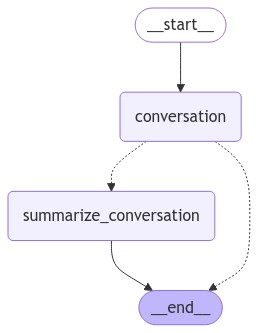

In [8]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

checkpointerは各ステップの状態をチェックポイントとして保存します。

これらの保存されたチェックポイントは、会話の `スレッド(thread)` にグループ化することができます。

Slackをアナログなものとして考えてみてください。異なるチャンネルは異なる会話を扱っています。

スレッドはSlackのチャンネルのようなもので、状態（例: 会話）のグループ化されたコレクションをキャプチャします。

以下では `configurable` を使ってスレッド ID を設定します。


![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [9]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="こんにちは! ランスです。")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="私の名前は?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="49ersが好きです!")  # 49ers はアメリカンフットボールのチーム
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

こんにちは、ランスさん！今日はどのようにお手伝いできますか？
================================== Ai Message ==================================

あなたの名前はランスさんですね。何か他にお手伝いできることがあれば教えてください！
================================== Ai Message ==================================

49ersが好きなんですね！サンフランシスコ・49ersは歴史あるNFLのチームで、多くのファンに愛されています。最近の試合や選手について何か特に興味があることはありますか？


6つ以下のメッセージしかないので、まだ状態の要約にはなりません。

これは、 `should_continue`.  で設定されています。

```
    # messagesが6つより多いなら、会話を要約する
    if len(messages) > 6:
        return "summarize_conversation"
```

スレッドを使っているので、会話を拾うことができます。

In [10]:
graph.get_state(config).values.get("summary", "")

''

スレッドID付きの`config`は、以前にログに記録された状態から処理を進めることができます！

In [11]:
input_message = HumanMessage(content="ニック・ボサが好き、ディフェンスが得意な選手で一番年俸が高いのでは？")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

はい、ニック・ボサはサンフランシスコ・49ersのディフェンスエンドとして非常に優れた選手です。彼は特にパスラッシュの能力で知られており、NFLの中でもトップクラスのディフェンシブプレイヤーの一人です。2023年には、彼がディフェンス選手として史上最高額の契約を結んだことが報じられました。彼のプレーはチームにとって非常に重要で、多くのファンに支持されていますね。


In [12]:
graph.get_state(config).values.get("summary", "")

'ランスさんはサンフランシスコ・49ersが好きで、特にディフェンスエンドのニック・ボサをお気に入りの選手として挙げています。ニック・ボサは優れたパスラッシュ能力を持ち、2023年にはディフェンス選手として史上最高額の契約を結んだことが話題になっています。彼のプレーはチームにとって重要で、多くのファンに支持されています。'

## LangSmith

Let's review the trace!